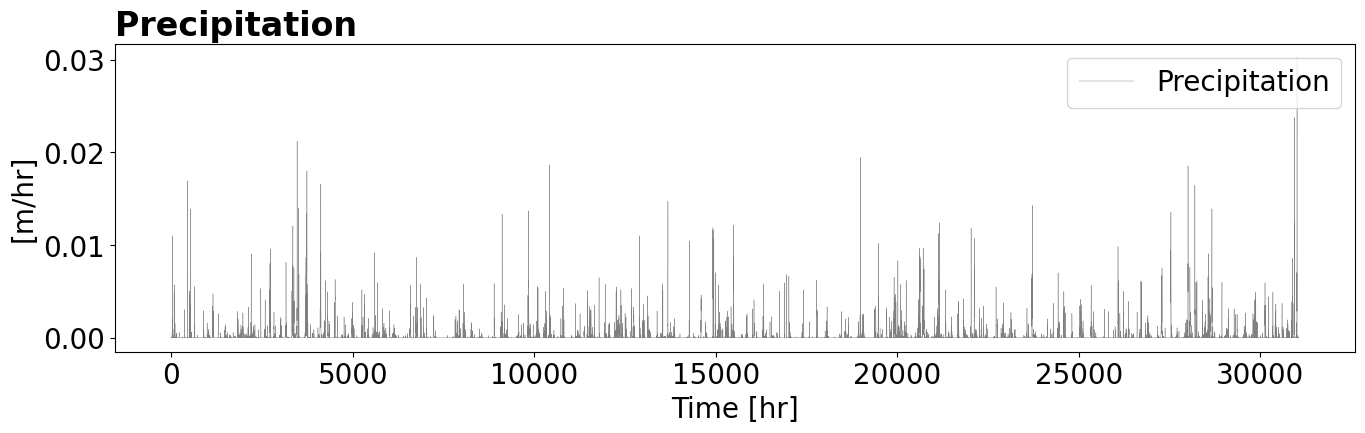

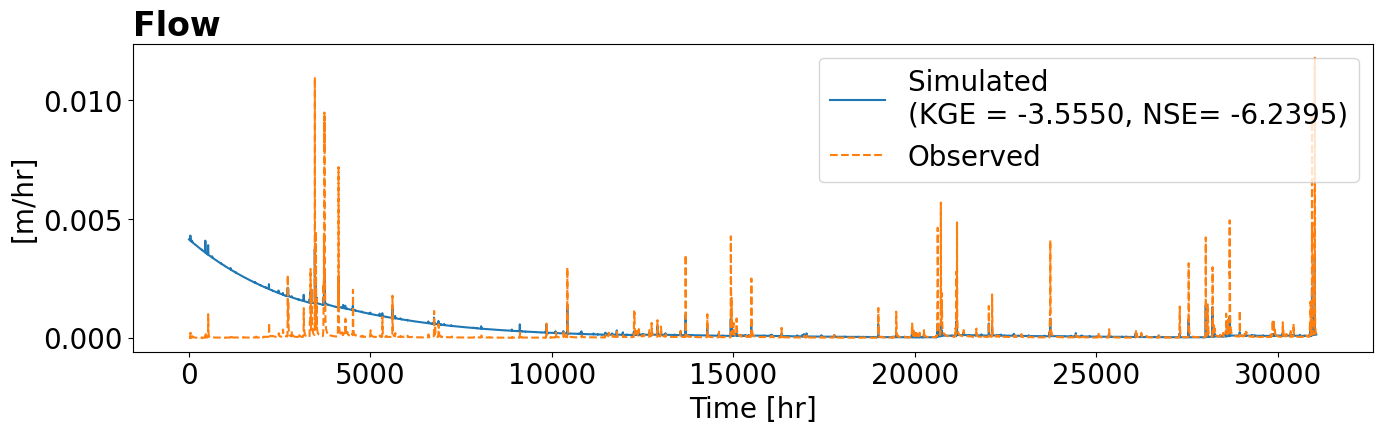

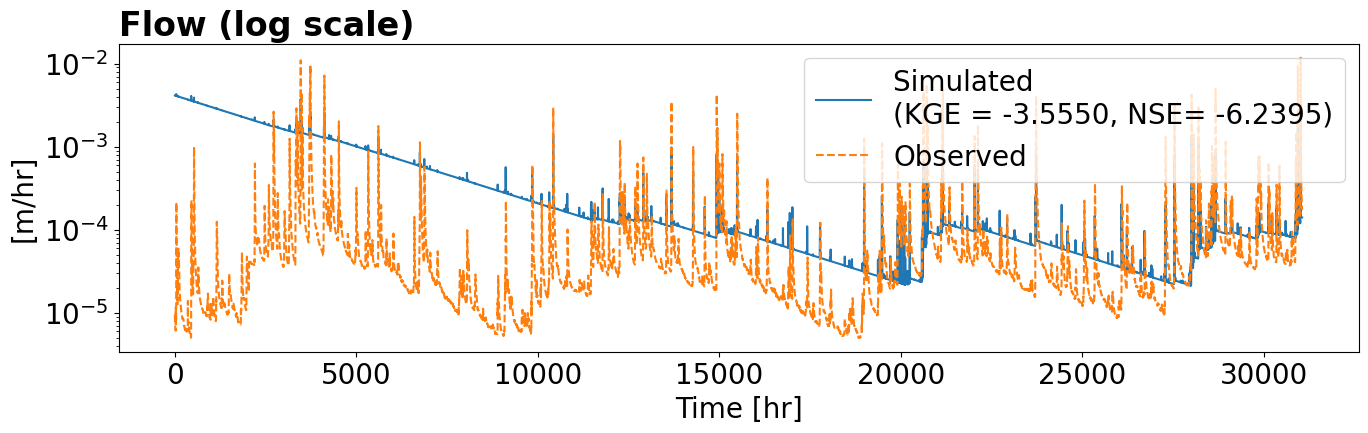

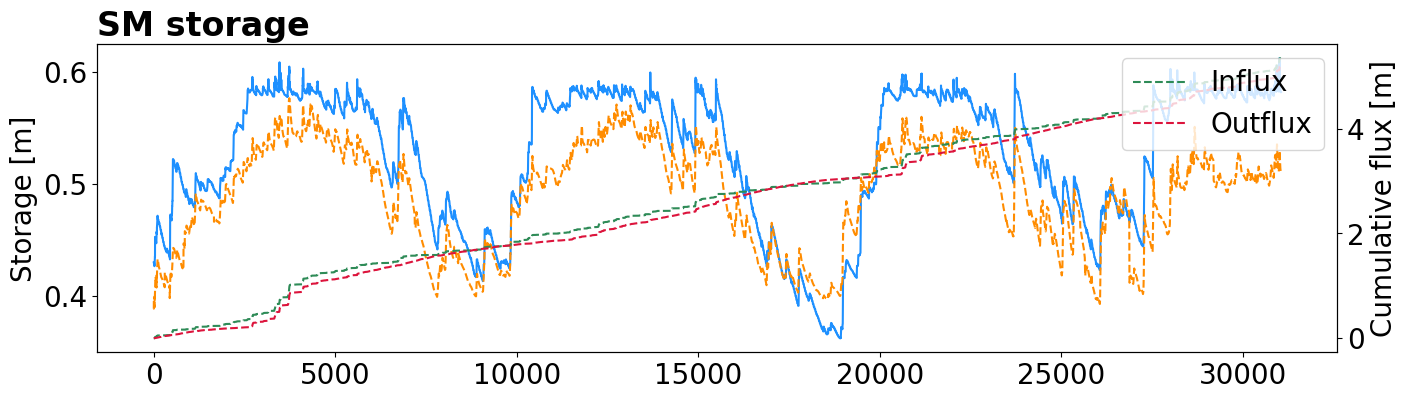

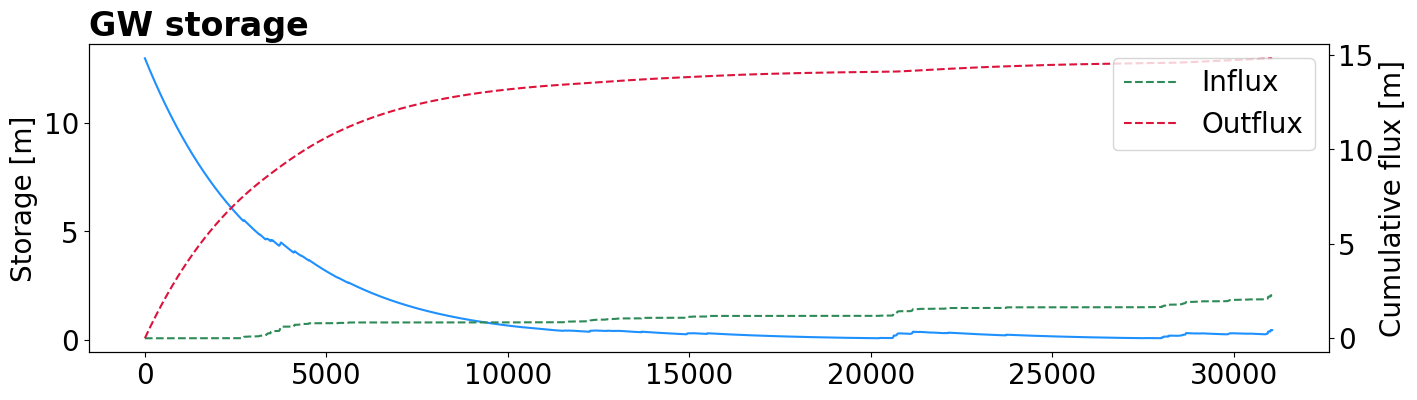

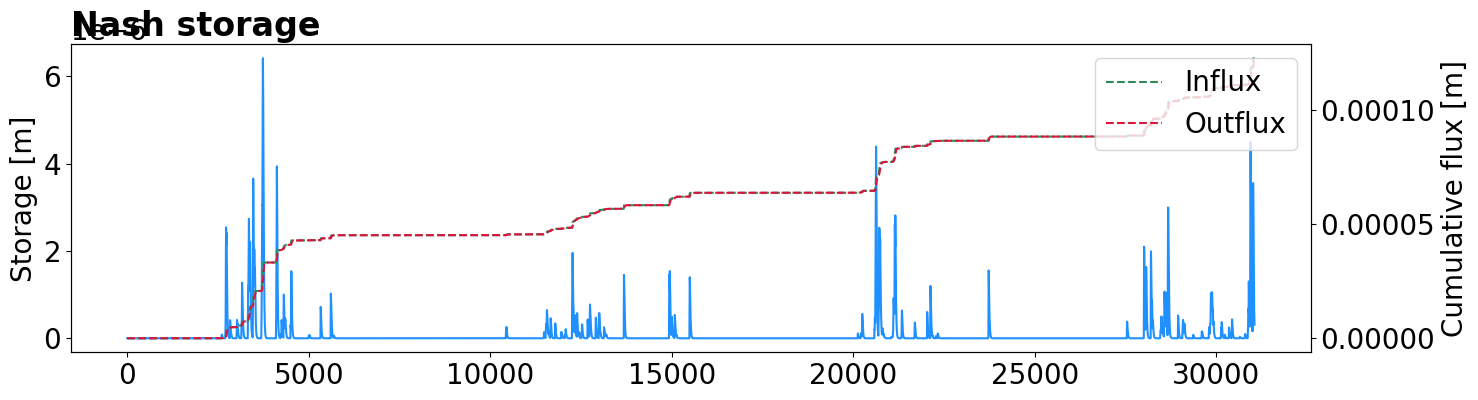

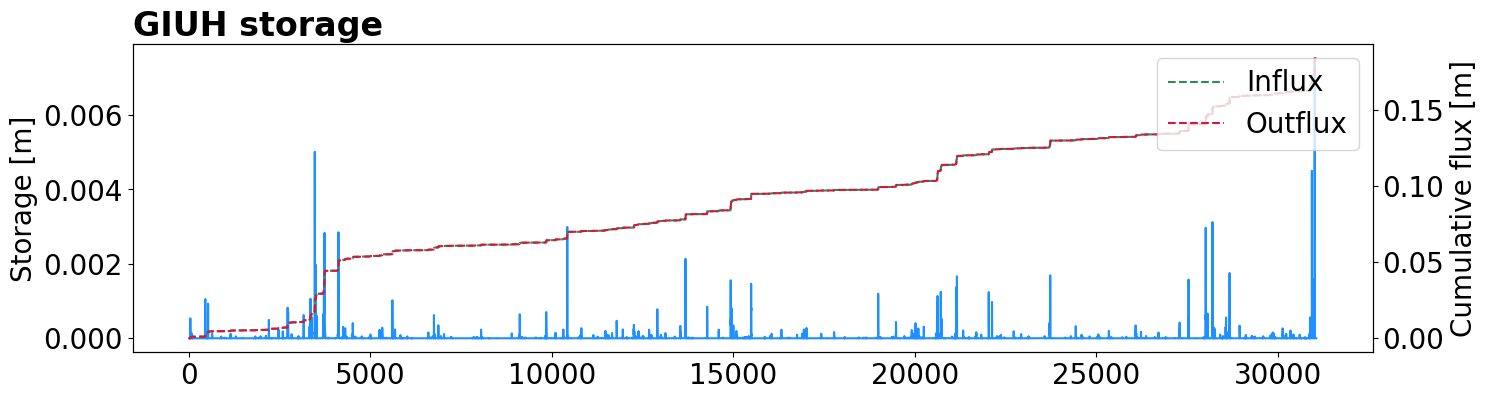

Evaluation in GLUE run was KGE on Flow    0.136314
Name: 6, dtype: float64
Evaluation based on the re-run was [-3.5549726809631075]


In [5]:
# A main module to run various analysis with CFE model
import os
import sys
os.chdir(r"G:\Araki\SMSigxModel\analysis\5_GLUE_MODEL")

# Import libraries
import spotpy
import numpy as np
import pandas as pd
import shutil
import json
sys.path.append(r"../libs/cfe/py_cfe")
import cfe
import bmi_cfe
sys.path.append(r"../libs/SMSig")
from sig_seasontrans import SMSig

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# =======================START OF THE CODE===================== #
# Settings
config_path_CFE = r'../2_data_input/Mahurangi/parameters/config_cfe_template.json'
config_path_GLUE = r'../6_out/Mahurangi/ws2_ex1.1/'
run_id = 6
eval_criteria = {
    0: {'variable_to_analyze': 'Flow', 'metric': 'KGE', 'threshold': 0.5}
}
var_names = ['Flow', 'Soil Moisture Content']


# Parameter bounds defined from an excel file
df_params = pd.read_csv(os.path.join(config_path_GLUE, 'paramter_priori.csv'), index_col=0)
df_evals = pd.read_csv(os.path.join(config_path_GLUE, 'evaluations.csv'), index_col=0)

# Write it
target_params = df_params.iloc[run_id].copy()
target_evals = df_evals.iloc[run_id].copy()

template_config_CFE = config_path_CFE
target_config_CFE = os.path.join(r"..\2_data_input\Mahurangi\parameters",
                                 f"config_cfe_{run_id}.json")
shutil.copyfile(template_config_CFE, target_config_CFE)

# Get the model config file
with open(target_config_CFE) as data_file:
    cfe_cfg = json.load(data_file)

# Overwrite the model config file
for i, target_para in enumerate(target_params.index):
    if target_para in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        cfe_cfg["soil_params"][target_para] = target_params[target_para]
    else:
        cfe_cfg[target_para] = target_params[target_para]

# Save the config file with new parameters
with open(target_config_CFE, 'w') as out_file:
    json.dump(cfe_cfg, out_file)

# Use it to run
myCFE = bmi_cfe.BMI_CFE(target_config_CFE)
myCFE.initialize()
sim0 = myCFE.run_unit_test(plot=True, warm_up=True)
obs0 = myCFE.load_unit_test_data()

# Sync
sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()

# Get the results
for var_name in var_names:
    # Get the simulated data
    sim = sim0[["Time", var_name]].copy()
    sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d %H:%M:%S")  # Works specifically for CFE

    # Get the comparison data
    obs = obs0[["Time", var_name]].copy()
    obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
    # obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

    # Merge observed and simulated timeseries
    df = pd.merge_asof(sim, obs, on="Time")
    df_timeaxis = df["Time"]

    sim_synced[var_name] = df[var_name + "_x"].copy()
    obs_synced[var_name] = df[var_name + "_y"].copy()

# Preparation
eval_result_for_a_run = []
# Loop for all evaluation metrics (multi-criteria).
# Calculate the metrics and judge behavioral vs. non-behavioral
for i in range(len(eval_criteria)):
    # Nash-Sutcliffe scores
    if eval_criteria[i]['metric'] == "NSE":
        metric_value = spotpy.objectivefunctions.nashsutcliffe(
            obs_synced[eval_criteria[i]['variable_to_analyze']],
            sim_synced[eval_criteria[i]['variable_to_analyze']]
        )

    # Kling-Gupta Efficiency scores
    # 　Kling-Gupta efficiencies range from -Inf to 1. Essentially, the closer to 1, the more accurate the model is
    elif eval_criteria[i]['metric'] == "KGE":
        metric_value = spotpy.objectivefunctions.kge(
            obs_synced[eval_criteria[i]['variable_to_analyze']],
            sim_synced[eval_criteria[i]['variable_to_analyze']]
        )

    # Seasonal transition dates
    elif eval_criteria[i]['metric'] == "season_transition":
        # Calculate metrics for OBSERVED timeseries as a baseline performance. Run only once
        # if n == 0:
        sig_obs = SMSig(
            ts_time=df["Time"].to_numpy(),
            ts_value=obs_synced[eval_criteria[i]['variable_to_analyze']].to_numpy(),
            plot_results=False,
            plot_label="obs"
        )
        # sig_obs.detrend() # TODO:debug
        sig_obs.movmean()
        t_valley = sig_obs.calc_sinecurve()
        season_trans_obs, _, _ = sig_obs.calc_seasontrans(t_valley=t_valley)

        # Calculate metrics for SIMULATED timeseries
        sig_sim = SMSig(
            ts_time=df["Time"].to_numpy(),
            ts_value=sim_synced[eval_criteria[i]['variable_to_analyze']].to_numpy(),
            plot_results=False,
            plot_label="sim"
        )
        sig_sim.movmean()
        season_trans_sim, _, _ = sig_sim.calc_seasontrans(t_valley=t_valley)

        # Get the deviations in seasonal transition dates between simulated and observed timeseries
        diff = season_trans_sim - season_trans_obs
        metric_value = abs(np.nanmean(diff, axis=0))

    # Store evaluation metrics for all criteria for one run
    eval_result_for_a_run.append(metric_value)

print(f"Evaluation in GLUE run was {target_evals}")
print(f"Evaluation based on the re-run was {eval_result_for_a_run}")